# Import data

$$
\langle T_{ij} \rangle = T_i\cdot \frac{m_i\cdot n_j}{(m_i+s_{ij})(m_i+n_j+s_{ij})}
$$
in which:
$$
T_i=\sum_{j\neq i}T_{ij}
$$
and $\langle T_{ij} \rangle$ means tha mean value of $T_{ij}$ within a period of time. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
path = '/Users/paw_paw/Library/Mobile Documents/com~apple~CloudDocs/学习/PC5287_M.SC Coursework Thesis for Physics And Technology/data set'

In [3]:
Prediction = pd.read_csv(path+'/Prediction2019_gpr.csv')
Prediction.set_index('PA_name',inplace=True)
#Prediction.mask(Prediction==0,np.nan,inplace=True)

In [4]:
flux=pd.read_csv(path+'/Total_flux_ij_2019.csv',index_col='PA_name')
#flux.mask(flux==0,np.nan,inplace=True)

# Evaluation

## Creat the graph

In [5]:
Z1 = np.log(Prediction)
Z2 = np.log(flux)
Z1.replace([np.inf, -np.inf], np.nan, inplace=True)
Z2.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/paw_paw/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


deleting the "No Man's Lands"

In [6]:
empty_pa= ['CENTRAL WATER CATCHMENT',\
               'LIM CHU KANG',\
               'NORTH-EASTERN ISLANDS',\
               'SIMPANG',\
               'SOUTHERN ISLANDS',\
               'MARINA EAST',\
               'CHANGI BAY']

|index|Planning Area|
| --- | --- |
| 0 | CENTRAL WATER CATCHMENT |
| 1 | CHANGI BAY |
| 2 | LIM CHU KANG |
| 3 | MARINA EAST |
| 4 | MARINA SOUTH |
| 5 | NORTH-EASTERN ISLANDS |
| 6 | PAYA LEBAR |
| 7 | SELETAR |
| 8 | SIMPANG |
| 9 | SOUTHERN ISLANDS |
| 10 | WESTERN ISLANDS |
| 11 | WESTERN WATER CATCHMENT |

In [7]:
def erase_pre(empty_pa):
    return Z1.drop(columns=empty_pa)[Z1.index!=empty_pa]

def erase_true(empty_pa):
    return Z2.drop(columns=empty_pa)[Z2.index!=empty_pa]

for pa in empty_pa:
    try:
        Z1 = erase_pre(pa)
        Z2 = erase_true(pa)
    except KeyError:
        pass

In [8]:
def remove_diag(x):
    for i in range(0,Z1.shape[0]):
        x.iat[i,i]=None
    return x

Z1=remove_diag(Z1)

Z2=remove_diag(Z2)

In [9]:
np.diagonal(Z1)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

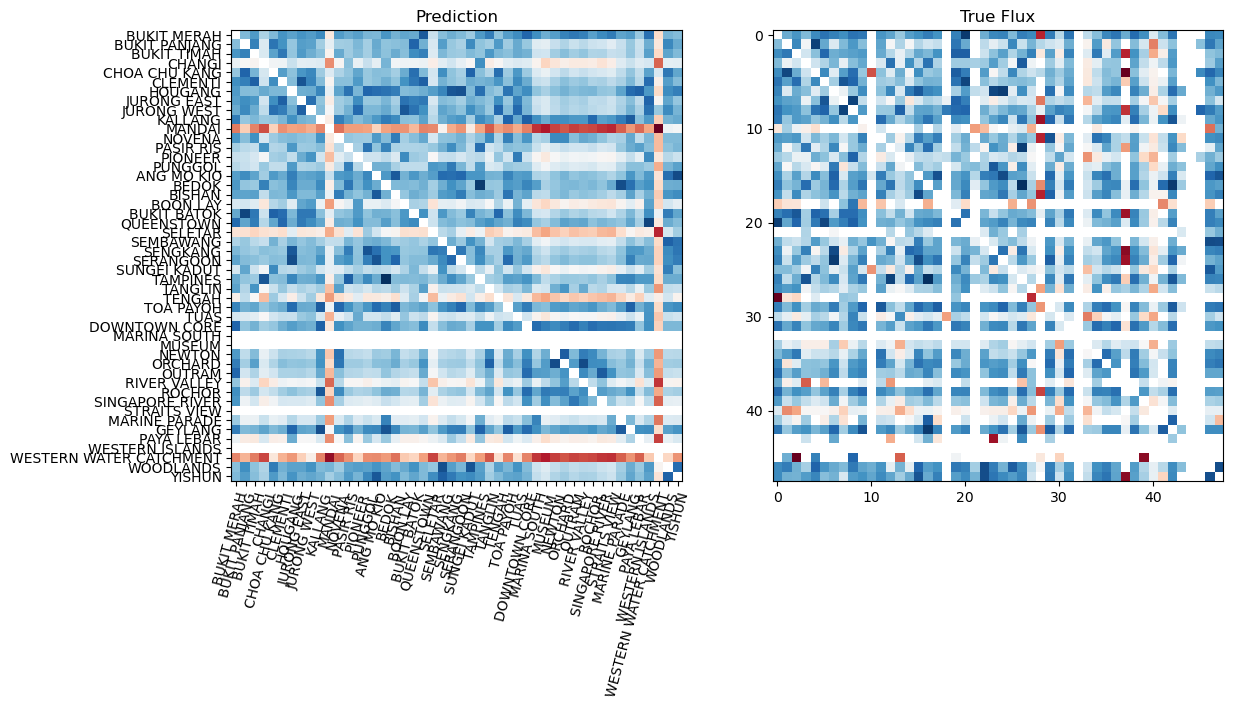

In [10]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches([12.8,9.6])


ax[0].imshow(Z1, cmap='RdBu', interpolation='nearest')
ax[0].set(xticks=np.arange(Z1.shape[0]), xticklabels=Z1.index,\
          yticks=np.arange(Z1.shape[1]), yticklabels=Z1.columns ,\
          title='Prediction',autoscale_on=True)

plt.setp(ax[0].get_xticklabels(), rotation=75, ha="right",
         rotation_mode="anchor")


ax[1].imshow(Z2, cmap='RdBu', interpolation='nearest')
ax[1].set(title='True Flux')

fig.savefig(path+'/Prediction_2019.png')

plt.show()

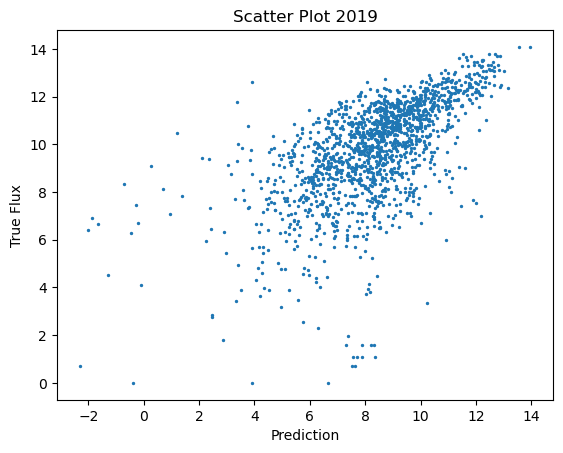

In [11]:
#Scatter plot 
plt.scatter(Z1,Z2,s=2)
plt.xlabel('Prediction')
plt.ylabel('True Flux')
plt.title('Scatter Plot 2019')

# To show the plot
plt.show()

## Metrics To Evaluate

### R2_score

|PA|type|
|---|---|
|MANDAI|Zoo|
|BOON LAY||
|RIVER VALLEY|private property for high income sections of the population|
|MARINE PARADE||


In [12]:
from numpy import NaN,Inf
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.impute import KNNImputer,SimpleImputer

In [13]:
X1=Z1
X2=Z2

# impute the missing data 
for i in X1.columns:
    for j in X1.index:
        if X2.isna()[i][j]:
            X1[i][j]=np.nan
            
imp = KNNImputer(n_neighbors=2)

X1=imp.fit_transform(X1)
X2=imp.fit_transform(X2)

R2=r2_score(X2,X1)

print('R2=',R2)

R2= -1.627249167904741


In [14]:
X1=Z1.to_numpy().flatten()
X2=Z2.to_numpy().flatten()

while sum(np.isnan(X1))>0:
    try:
        for i in range(0,X1.size):
            if np.isnan(X1[i]) or np.isnan(X2[i]):
                X1=np.delete(X1,[i])
                X2=np.delete(X2,[i])
    except IndexError:
        continue

R2=r2_score(X2,X1)

print('R2=',R2)

R2= -0.21049370370095488


### Relative error

In [16]:
err = (Z1-Z2).abs()

rlt_err = (err/Z1).abs()

rlt_err_aprx=rlt_err.replace([-np.inf,np.inf], np.nan,inplace=False)

rlt_err_aprx=rlt_err_aprx.fillna(0)

In [17]:
for i in range(0,Z2.shape[0]):
    for j in range(0,Z2.shape[0]):
        if rlt_err_aprx.values[i,j]>=0.8:
            rlt_err_aprx.values[i,j]=1
        else:
            rlt_err_aprx.values[i,j]=0

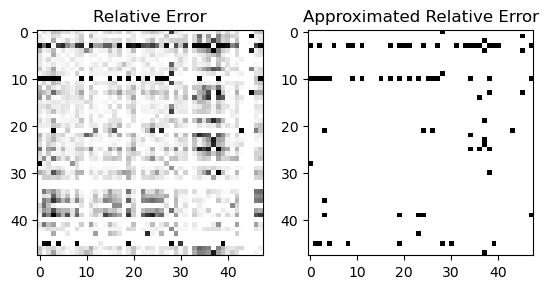

In [18]:
fig, ax = plt.subplots(1,2)

z1 = rlt_err
z2 = rlt_err_aprx


ax[0].imshow(z1, cmap='Greys', interpolation='nearest',vmin=0, vmax=1)
ax[0].set(title='Relative Error',autoscale_on=True)

ax[1].imshow(z2, cmap='Greys', interpolation='nearest',vmin=0, vmax=1)
ax[1].set(title='Approximated Relative Error',autoscale_on=True)

plt.show()

相对误差大于80%视为无效,小于视为有效。

In [19]:
sum(sum(1-rlt_err_aprx.values))/rlt_err.size

0.9665798611111112